**loading the data**

In [10]:
import pandas as pd

# Load your Excel dataset
file_path = "/content/discharge followup dataset final.xlsx"
df = pd.read_excel(file_path)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Shape: (600, 14)
Columns: ['Patient ID', 'Name', 'Age', 'Sex', 'Occupation Category', 'Insurance', 'Follow-up Date', 'Diagnosis', 'Follow-up Reason', 'Medications', 'Notes', 'Status', 'Condition Type', 'Discharge Date']


,Patient ID,Name,Age,Sex,Occupation Category,Insurance,Follow-up Date,Diagnosis,Follow-up Reason,Medications,Notes,Status,Condition Type,Discharge Date
0,P0001,Patient_1,67,Female,Self-employed,Yes,2025-10-04,UTI,Specialist consultation,Ciprofloxacin,Follow-up required for uti - specialist consul...,Upcoming,Acute,2025-09-25
1,P0002,Patient_2,18,Female,Unemployed,No,2025-08-28,Upper respiratory tract infection,Other,Paracetamol,Follow-up required for upper respiratory tract...,Overdue,Acute,2025-08-22
2,P0003,Patient_3,84,Male,Unemployed,Yes,2025-10-06,Gastrointestinal disorder,Specialist consultation,"Metronidazole, Ranitidine",Follow-up required for gastrointestinal disord...,Upcoming,Acute,2025-09-29
3,P0004,Patient_4,58,Male,Unemployed,No,2025-10-04,Pneumonia,Other,Amoxicillin,Follow-up required for pneumonia - other.,Upcoming,Acute,2025-09-25
4,P0005,Patient_5,87,Female,Unemployed,Yes,2025-09-09,UTI,Routine check-up,"Nitrofurantoin, Amoxicillin",Follow-up required for uti - routine check-up.,Overdue,Acute,2025-09-04


**Data cleaning and feature engineering**

In [12]:
import numpy as np
from datetime import date

# Parse dates
for col in ["Discharge Date", "Follow-up Date"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

# Days between discharge and follow-up
df["days_from_discharge_to_followup"] = (df["Follow-up Date"] - df["Discharge Date"]).dt.days

# Medications count
df["meds_count"] = df["Medications"].fillna("").apply(
    lambda s: 0 if s.strip()=="" else len([x for x in str(s).split(",") if x.strip()!=""])
)


# Fill missing Age / Sex if absent
if "Age" not in df.columns:
    df["Age"] = np.random.randint(18, 80, size=len(df))
if "Sex" not in df.columns:
    df["Sex"] = np.random.choice(["Female", "Male"], size=len(df))

# Condition type from Diagnosis
def classify_condition(d):
    chronic_keywords = ["diabetes", "hypertension", "arthritis", "asthma", "chronic", "hiv"]
    s = str(d).lower()
    return "Chronic" if any(kw in s for kw in chronic_keywords) else "Acute"

df["Condition Type"] = df["Diagnosis"].apply(classify_condition)

# Occupation category normalization
def norm_occ(x):
    s = str(x).lower()
    if "self" in s or "farmer" in s or "business" in s:
        return "Self-employed"
    elif "unemploy" in s or "student" in s:
        return "Unemployed"
    else:
        return "Employed"
df["Occupation Category"] = df["Occupation Category"].apply(norm_occ)

# Insurance normalization
df["Insurance"] = df["Insurance"].fillna("No").apply(
    lambda x: "Yes" if str(x).strip().lower() in ["yes","y","true","1"] else "No"
)

# Target variable: default (1 if overdue, 0 otherwise)
df["is_default"] = df["Status"].apply(lambda s: 1 if str(s).lower()=="overdue" else 0)

df.head()

,Patient ID,Name,Age,Sex,Occupation Category,Insurance,Follow-up Date,Diagnosis,Follow-up Reason,Medications,Notes,Status,Condition Type,Discharge Date,days_from_discharge_to_followup,meds_count,is_default
0,P0001,Patient_1,67,Female,Self-employed,Yes,2025-10-04,UTI,Specialist consultation,Ciprofloxacin,Follow-up required for uti - specialist consul...,Upcoming,Acute,2025-09-25,9,1,0
1,P0002,Patient_2,18,Female,Unemployed,No,2025-08-28,Upper respiratory tract infection,Other,Paracetamol,Follow-up required for upper respiratory tract...,Overdue,Acute,2025-08-22,6,1,1
2,P0003,Patient_3,84,Male,Unemployed,Yes,2025-10-06,Gastrointestinal disorder,Specialist consultation,"Metronidazole, Ranitidine",Follow-up required for gastrointestinal disord...,Upcoming,Acute,2025-09-29,7,2,0
3,P0004,Patient_4,58,Male,Unemployed,No,2025-10-04,Pneumonia,Other,Amoxicillin,Follow-up required for pneumonia - other.,Upcoming,Acute,2025-09-25,9,1,0
4,P0005,Patient_5,87,Female,Unemployed,Yes,2025-09-09,UTI,Routine check-up,"Nitrofurantoin, Amoxicillin",Follow-up required for uti - routine check-up.,Overdue,Acute,2025-09-04,5,2,1


## **visualization(EDA)**

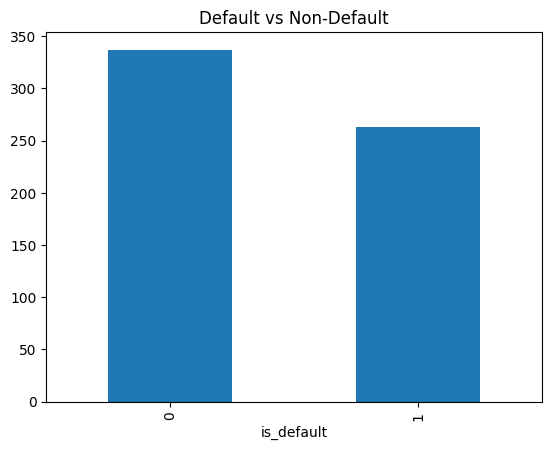

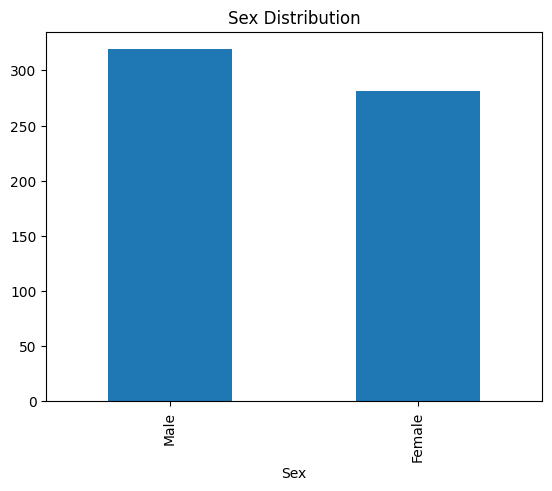

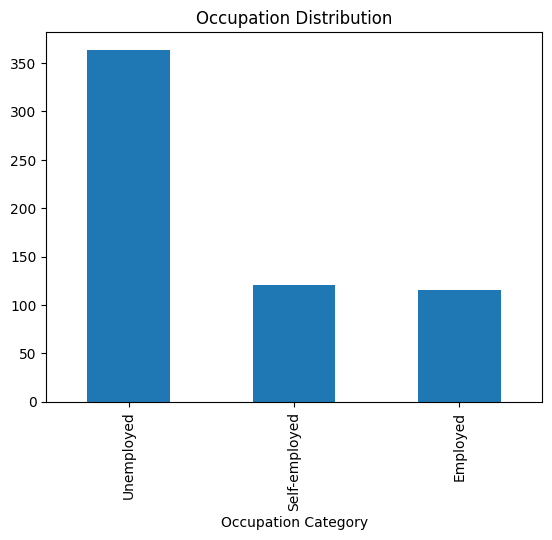

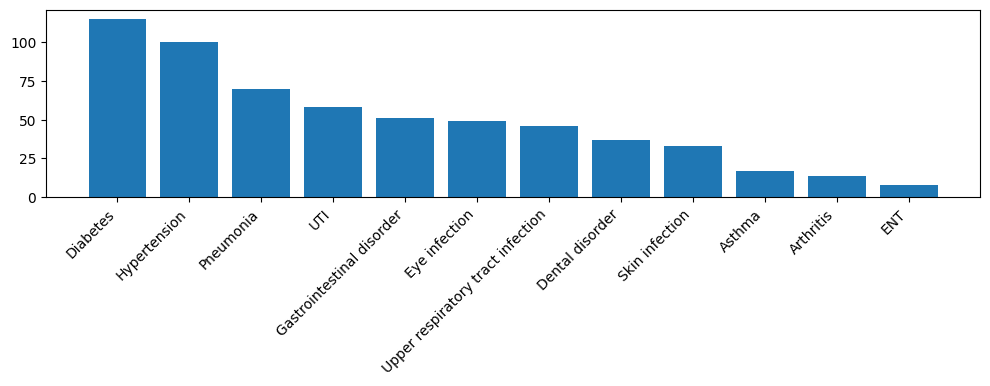

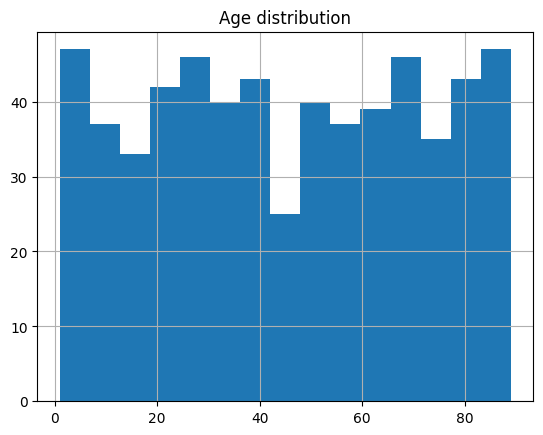

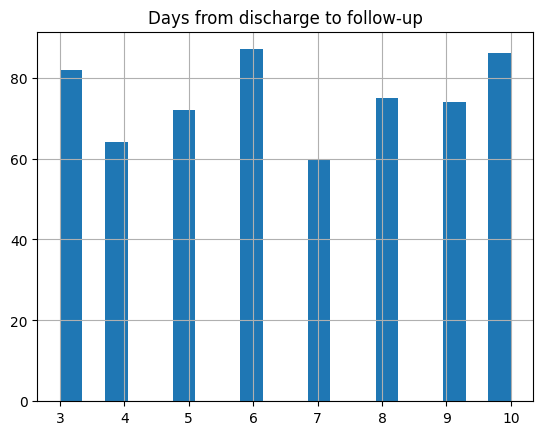

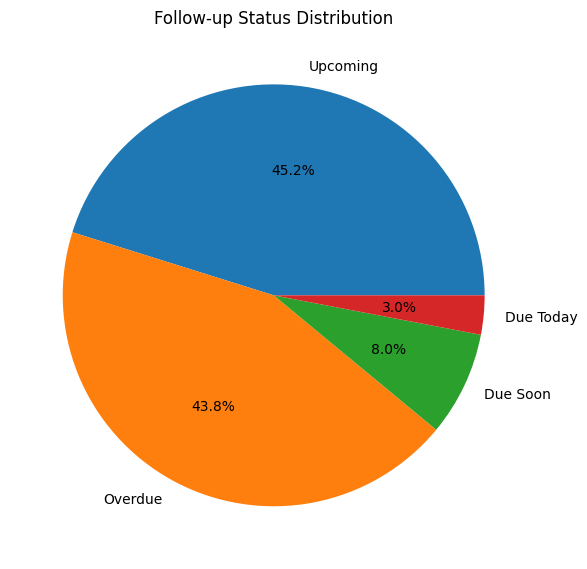

In [16]:
import matplotlib.pyplot as plt

# Default distribution
df["is_default"].value_counts().plot(kind="bar", title="Default vs Non-Default")
plt.show()

# Sex distribution
df["Sex"].value_counts().plot(kind="bar", title="Sex Distribution")
plt.show()

# Occupation distribution
df["Occupation Category"].value_counts().plot(kind="bar", title="Occupation Distribution")
plt.show()


# Bar chart: top diagnoses
top_diag = df['Diagnosis'].value_counts().nlargest(12)
plt.figure(figsize=(10,4))
plt.bar(top_diag.index, top_diag.values)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("bar_top_diagnoses.png")
plt.show()

# Age distribution
df["Age"].hist(bins=15)
plt.title("Age distribution")
plt.show()

# Days between discharge & follow-up
df["days_from_discharge_to_followup"].hist(bins=20)
plt.title("Days from discharge to follow-up")
plt.show()


# Pie chart: status distribution
status_counts = df['Status'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(status_counts.values, labels=status_counts.index, autopct="%1.1f%%")
plt.title("Follow-up Status Distribution")
plt.tight_layout()
plt.savefig("pie_status.png")
plt.show()


**Preparing features for modelling(training the model)**

In [17]:
from sklearn.model_selection import train_test_split

# Select features
features = ["days_from_discharge_to_followup", "meds_count", "Age",
            "Diagnosis", "Follow-up Reason", "Sex",
            "Occupation Category", "Insurance", "Condition Type"]

X = df[features].copy()
y = df["is_default"]

# Handle missing values
for c in X.select_dtypes(include=[np.number]).columns:
    X[c] = X[c].fillna(X[c].median())
for c in X.select_dtypes(include=["object"]).columns:
    X[c] = X[c].fillna("Missing")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


**Model evaluation**

In [18]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Define preprocessing
numeric_features = ["days_from_discharge_to_followup", "meds_count", "Age"]
categorical_features = ["Diagnosis", "Follow-up Reason", "Sex", "Occupation Category", "Insurance", "Condition Type"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

# Try multiple models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}
for name, clf in models.items():
    pipe = Pipeline([("preprocessor", preprocessor), ("classifier", clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"{name} - Accuracy: {acc:.3f}, ROC AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))

    results[name] = pipe


LogisticRegression - Accuracy: 0.425, ROC AUC: 0.464
              precision    recall  f1-score   support

           0       0.48      0.43      0.46        67
           1       0.37      0.42      0.39        53

    accuracy                           0.42       120
   macro avg       0.42      0.42      0.42       120
weighted avg       0.43      0.42      0.43       120

RandomForest - Accuracy: 0.508, ROC AUC: 0.472
              precision    recall  f1-score   support

           0       0.55      0.64      0.59        67
           1       0.43      0.34      0.38        53

    accuracy                           0.51       120
   macro avg       0.49      0.49      0.49       120
weighted avg       0.50      0.51      0.50       120

GradientBoosting - Accuracy: 0.583, ROC AUC: 0.579
              precision    recall  f1-score   support

           0       0.63      0.61      0.62        67
           1       0.53      0.55      0.54        53

    accuracy                   

**Saving the model**

In [19]:
import joblib

# Choose best model (say GradientBoosting)
best_model = results["GradientBoosting"]

# Save it
joblib.dump(best_model, "followup_default_pipeline.joblib")
print(" Model saved: followup_default_pipeline.joblib")


 Model saved: followup_default_pipeline.joblib


In [21]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 104.9 MB/s eta 0:00:00


In [25]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib
from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ---------------- Config ----------------
FOLLOWUPS_FILE = "current_followups.xlsx"
HISTORY_FILE = "followup_history.xlsx"
MODEL_PATH = "followup_default_pipeline.joblib"  # if present, will be used

# ---------------- Enhanced Styling ----------------
st.set_page_config(page_title="Discharge Follow-up Dashboard", layout="wide", page_icon="🏥")
st.markdown("""
<style>
    /* Main styling */
    .main-header {
        font-size: 3rem !important;
        color: #1a5276;
        margin-bottom: 1rem;
        text-align: center;
        font-weight: 700;
        background: linear-gradient(135deg, #1a5276, #3498db);
        -webkit-background-clip: text;
        -webkit-text-fill-color: transparent;
        padding: 1rem;
    }

    .subheader {
        font-size: 1.8rem !important;
        color: #2c3e50;
        border-bottom: 3px solid #3498db;
        padding-bottom: 0.5rem;
        margin-top: 2rem;
        margin-bottom: 1.5rem;
        font-weight: 600;
    }

    /* Enhanced metric cards */
    .metric-card {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        padding: 1.5rem;
        border-radius: 15px;
        text-align: center;
        box-shadow: 0 4px 15px rgba(0,0,0,0.1);
        transition: transform 0.3s ease;
        color: white;
    }

    .metric-card:hover {
        transform: translateY(-5px);
    }

    .metric-value {
        font-size: 2.2rem !important;
        font-weight: bold;
        margin-bottom: 0.5rem;
    }

    .metric-label {
        font-size: 1rem !important;
        opacity: 0.9;
    }

    /* Form styling */
    .stForm {
        background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%);
        padding: 2rem;
        border-radius: 15px;
        box-shadow: 0 4px 15px rgba(0,0,0,0.1);
    }

    /* Button styling */
    .stButton button {
        background: linear-gradient(135deg, #3498db, #2980b9);
        color: white;
        border: none;
        padding: 0.5rem 2rem;
        border-radius: 25px;
        font-weight: 600;
        transition: all 0.3s ease;
    }

    .stButton button:hover {
        transform: translateY(-2px);
        box-shadow: 0 5px 15px rgba(52, 152, 219, 0.4);
    }

    /* Expander styling */
    .streamlit-expanderHeader {
        background: linear-gradient(135deg, #74b9ff, #0984e3) !important;
        color: white !important;
        border-radius: 10px !important;
        font-weight: 600 !important;
    }

    /* Dataframe styling */
    .stDataFrame {
        border-radius: 10px;
        box-shadow: 0 4px 15px rgba(0,0,0,0.1);
    }

    /* Success/Info/Warning styling */
    .stSuccess {
        background: linear-gradient(135deg, #00b894, #00a085) !important;
        color: white !important;
        border-radius: 10px;
        padding: 1rem;
    }

    .stInfo {
        background: linear-gradient(135deg, #74b9ff, #0984e3) !important;
        color: white !important;
        border-radius: 10px;
        padding: 1rem;
    }

    .stWarning {
        background: linear-gradient(135deg, #fdcb6e, #e17055) !important;
        color: white !important;
        border-radius: 10px;
        padding: 1rem;
    }

    /* Custom section backgrounds */
    .section-container {
        background: linear-gradient(135deg, #f8f9fa, #e9ecef);
        padding: 2rem;
        border-radius: 15px;
        margin: 1rem 0;
        box-shadow: 0 4px 15px rgba(0,0,0,0.1);
    }

    /* Status badges */
    .status-overdue { background: linear-gradient(135deg, #e74c3c, #c0392b); color: white; padding: 0.3rem 0.8rem; border-radius: 20px; font-weight: 600; }
    .status-due-today { background: linear-gradient(135deg, #e67e22, #d35400); color: white; padding: 0.3rem 0.8rem; border-radius: 20px; font-weight: 600; }
    .status-due-tomorrow { background: linear-gradient(135deg, #f39c12, #e67e22); color: white; padding: 0.3rem 0.8rem; border-radius: 20px; font-weight: 600; }
    .status-due-soon { background: linear-gradient(135deg, #f1c40f, #f39c12); color: white; padding: 0.3rem 0.8rem; border-radius: 20px; font-weight: 600; }
    .status-upcoming { background: linear-gradient(135deg, #27ae60, #2ecc71); color: white; padding: 0.3rem 0.8rem; border-radius: 20px; font-weight: 600; }

    /* Risk level styling */
    .risk-high { background: linear-gradient(135deg, #e74c3c, #c0392b); color: white; padding: 0.3rem 0.8rem; border-radius: 20px; font-weight: 600; }
    .risk-medium { background: linear-gradient(135deg, #f39c12, #e67e22); color: white; padding: 0.3rem 0.8rem; border-radius: 20px; font-weight: 600; }
    .risk-low { background: linear-gradient(135deg, #27ae60, #2ecc71); color: white; padding: 0.3rem 0.8rem; border-radius: 20px; font-weight: 600; }
</style>
""", unsafe_allow_html=True)

# ------------------ Helpers ------------------
def try_load_model(path=MODEL_PATH):
    """Try to load a joblib sklearn pipeline. Return pipeline or None."""
    if os.path.exists(path):
        try:
            return joblib.load(path)
        except Exception as e:
            st.warning(f"Model file found but failed to load: {e}. Falling back to heuristic.")
            return None
    return None

@st.cache_data
def load_followups_cached():
    """Load the current follow-ups file (cached)."""
    if os.path.exists(FOLLOWUPS_FILE):
        df = pd.read_excel(FOLLOWUPS_FILE)
        for col in ["Discharge Date", "Follow-up Date"]:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors="coerce")
        return df
    else:
        cols = [
            "Patient ID","Name","Age","Sex","Occupation Category","Insurance","Telephone",
            "Discharge Date","Follow-up Date","Diagnosis","Condition Type","Follow-up Reason",
            "Medications","Notes","Status","Recommendation","Predicted Probability","Risk Level"
        ]
        df = pd.DataFrame(columns=cols)
        df.to_excel(FOLLOWUPS_FILE, index=False)
        return df

@st.cache_data
def load_history_cached():
    """Load the history file (cached)."""
    if os.path.exists(HISTORY_FILE):
        df = pd.read_excel(HISTORY_FILE)
        for col in ["Discharge Date", "Follow-up Date", "Entry Date"]:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors="coerce")
        return df
    else:
        cols = [
            "Patient ID","Name","Age","Sex","Occupation Category","Insurance","Telephone",
            "Discharge Date","Follow-up Date","Diagnosis","Condition Type","Follow-up Reason",
            "Medications","Notes","Status","Recommendation","Predicted Probability","Risk Level",
            "Entry Date","Entry Type"
        ]
        df = pd.DataFrame(columns=cols)
        df.to_excel(HISTORY_FILE, index=False)
        return df

def save_followups(df):
    for col in ["Discharge Date","Follow-up Date"]:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")
    df.to_excel(FOLLOWUPS_FILE, index=False)

def save_history(df):
    for col in ["Discharge Date","Follow-up Date","Entry Date"]:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")
    df.to_excel(HISTORY_FILE, index=False)

def add_history_entry(entry_dict, entry_type="New Entry"):
    hist = load_history_cached()
    e = entry_dict.copy()
    e["Entry Date"] = datetime.now()
    e["Entry Type"] = entry_type
    hist = pd.concat([hist, pd.DataFrame([e])], ignore_index=True)
    save_history(hist)
    # clear cache so subsequent reads reflect saved history
    st.cache_data.clear()

def classify_condition_from_diag(diag):
    diag = str(diag).lower()
    chronic_keywords = ["diabetes","hypertension","arthritis","asthma","chronic","hiv"]
    return "Chronic" if any(k in diag for k in chronic_keywords) else "Acute"

def compute_status_and_days(fup_date):
    """Return (status, days) given a follow-up date-like object."""
    fup = pd.to_datetime(fup_date).date()
    today = date.today()
    days = (fup - today).days
    if days < 0:
        status = "Overdue"
    elif days == 0:
        status = "Due Today"
    elif days == 1:
        status = "Due Tomorrow"
    elif days <= 3:
        status = "Due Soon"
    else:
        status = "Upcoming"
    return status, int(days)

def get_recommendation(status, days):
    if status == "Overdue":
        overdue_by = abs(days)
        if overdue_by == 1:
            return f"⚠️ Overdue by 1 day — call patient immediately or escalate to physician."
        else:
            return f"⚠️ Overdue by {overdue_by} days — call patient immediately or escalate to physician."
    elif status == "Due Today":
        return "📞 Due today — remind patient to attend follow-up today."
    elif status == "Due Tomorrow":
        return "📌 Due tomorrow — 1 day remaining. Prepare reminder for tomorrow."
    elif status == "Due Soon":
        return f"📌 Due soon — {days} days remaining. Prepare reminder within the next {days} day(s)."
    else:
        return f"✅ Upcoming — {days} days remaining. No immediate action needed."

# ------------------ Prediction helpers ------------------
MODEL = try_load_model()

def heuristic_probability(days_from_discharge, days_until_followup, meds_count, age, telephone_provided, condition_type):
    """
    Simple rule-based fallback to estimate probability [0..1].
    Interpretable and deterministic (used if no trained model is available).
    """
    prob = 0.35  # baseline
    # longer gap between discharge and followup => higher chance of default
    if pd.isna(days_from_discharge):
        days_from_discharge = days_until_followup if not pd.isna(days_until_followup) else 7
    if days_from_discharge >= 60:
        prob += 0.18
    elif days_from_discharge >= 30:
        prob += 0.10
    elif days_from_discharge <= 7:
        prob -= 0.05

    # follow-up soon vs overdue
    if not pd.isna(days_until_followup):
        if days_until_followup < 0:
            prob += 0.2
        elif days_until_followup == 0:
            prob += 0.05
        elif days_until_followup == 1:
            prob += 0.02

    # meds_count -> more meds often indicates follow-up is necessary (reduce default slightly)
    if meds_count >= 3:
        prob -= 0.06
    elif meds_count == 0:
        prob += 0.03

    # telephone reduces default
    if telephone_provided:
        prob -= 0.08
    else:
        prob += 0.06

    # age effect slight
    if age >= 65:
        prob -= 0.04
    elif age <= 25:
        prob += 0.03

    # chronic conditions might have lower default (they often return) - adjust slightly
    if str(condition_type).lower() == "chronic":
        prob -= 0.03

    # clamp
    prob = max(0.01, min(0.99, prob))
    return prob

def predict_probability_from_model(row_df):
    """
    Try to predict with loaded MODEL pipeline (if available).
    The pipeline used when training should have used these feature column names:
      ['days_from_discharge_to_followup','meds_count','Age','Diagnosis','Follow-up Reason',
       'Sex','Occupation Category','Insurance','Condition Type']
    If MODEL is missing or prediction fails, return None.
    """
    if MODEL is None:
        return None
    try:
        # ensure columns exist in row_df (fill missing ones with defaults)
        expected = ['days_from_discharge_to_followup','meds_count','Age','Diagnosis','Follow-up Reason',
                    'Sex','Occupation Category','Insurance','Condition Type']
        for col in expected:
            if col not in row_df.columns:
                row_df[col] = ""  # safe default; numeric transformers will coerce later if needed
        proba = MODEL.predict_proba(row_df[expected])[0,1]
        # clamp & return
        proba = float(max(0.0, min(1.0, proba)))
        return proba
    except Exception as e:
        # model failed for this input shape; fall back to heuristic
        st.info(f"Model prediction failed: {e}. Using heuristic estimator.")
        return None

def compute_prediction_and_risk(days_from_discharge, days_until_followup, meds_count, age, telephone_provided, condition_type, row_for_model):
    # 1) try model
    proba = predict_probability_from_model(row_for_model)
    # 2) fallback to heuristic
    if proba is None:
        proba = heuristic_probability(days_from_discharge, days_until_followup, meds_count, age, telephone_provided, condition_type)
    # risk label
    if proba >= 0.70:
        risk = "High"
    elif proba >= 0.40:
        risk = "Medium"
    else:
        risk = "Low"
    return float(proba), risk

# ------------------ App start ------------------
st.markdown('<h1 class="main-header">🏥 Discharge Follow-up & Reminder Dashboard</h1>', unsafe_allow_html=True)

# load data (cached)
df_followups = load_followups_cached()
df_history = load_history_cached()

# ------------------ FORM ------------------
with st.expander("➕ Add New Follow-up Record", expanded=True):
    with st.form("followup_form", clear_on_submit=True):
        st.markdown("### 📝 Patient Information")
        col1, col2 = st.columns(2)
        with col1:
            patient_id = st.text_input("Patient ID", value=f"P{len(df_followups)+1:04d}")
            name = st.text_input("Patient Name")
            age = st.number_input("Age", min_value=0, max_value=120, step=1, value=40)
            sex = st.selectbox("Sex", options=["Female","Male"])
            occupation = st.selectbox("Occupation Category", options=["Employed","Self-employed","Unemployed"])
            insurance = st.selectbox("Insurance", options=["Yes","No"])
            telephone = st.text_input("Telephone Number")
        with col2:
            discharge_date = st.date_input("Discharge Date", value=date.today())
            follow_up_date = st.date_input("Follow-up Date", value=date.today())
            diagnosis = st.text_input("Diagnosis")
            # auto-suggest condition type from diagnosis, but allow manual override
            suggested_condition = classify_condition_from_diag(diagnosis) if diagnosis.strip()!="" else "Acute"
            condition_type = st.selectbox("Condition Type", options=["Chronic","Acute"], index=0 if suggested_condition=="Chronic" else 1)
            reason = st.text_input("Follow-up Reason")
            medications = st.text_input("Medications (comma separated)")
            notes = st.text_area("Notes (optional)")

        submitted = st.form_submit_button("💾 Save Follow-up Record")

        if submitted:
            # compute fields
            meds_count = 0 if str(medications).strip()=="" else len([m.strip() for m in medications.split(",") if m.strip()!=""])
            days_from_discharge = None
            try:
                days_from_discharge = (pd.to_datetime(follow_up_date) - pd.to_datetime(discharge_date)).days
            except Exception:
                days_from_discharge = np.nan
            days_until_followup = (pd.to_datetime(follow_up_date).date() - date.today()).days

            status, days = compute_status_and_days(follow_up_date)
            recommendation = get_recommendation(status, days)

            # prepare minimal row for model (attempt to match training features)
            row_for_model = pd.DataFrame([{
                'days_from_discharge_to_followup': days_from_discharge,
                'meds_count': meds_count,
                'Age': age,
                'Diagnosis': diagnosis,
                'Follow-up Reason': reason,
                'Sex': sex,
                'Occupation Category': occupation,
                'Insurance': insurance,
                'Condition Type': condition_type
            }])

            prob, risk = compute_prediction_and_risk(days_from_discharge, days_until_followup, meds_count, age, bool(str(telephone).strip()), condition_type, row_for_model)

            new_row = {
                "Patient ID": patient_id,
                "Name": name,
                "Age": age,
                "Sex": sex,
                "Occupation Category": occupation,
                "Insurance": insurance,
                "Telephone": telephone,
                "Discharge Date": pd.to_datetime(discharge_date),
                "Follow-up Date": pd.to_datetime(follow_up_date),
                "Diagnosis": diagnosis,
                "Condition Type": condition_type,
                "Follow-up Reason": reason,
                "Medications": medications,
                "Notes": notes,
                "Status": status,
                "Recommendation": recommendation,
                "Predicted Probability": round(prob, 3),
                "Risk Level": risk
            }

            # append to followups and save
            df_followups = pd.concat([df_followups, pd.DataFrame([new_row])], ignore_index=True)
            save_followups(df_followups)

            # add history entry
            add_history_entry(new_row, "New Entry")

            # clear caches and reload so UI reflects saved data immediately
            st.cache_data.clear()
            df_followups = load_followups_cached()
            df_history = load_history_cached()

            st.success(f"✅ Record saved successfully! Status: **{status}**")
            st.info(f"📊 Predicted default probability: {prob:.1%} | Risk Level: **{risk}**")
            st.markdown(f"💡 **Recommendation:** {recommendation}")

# ------------------ DASHBOARD METRICS ------------------
st.markdown('<h2 class="subheader">📊 Follow-up Overview</h2>', unsafe_allow_html=True)
# ensure Follow-up Date dtype
if "Follow-up Date" in df_followups.columns:
    df_followups["Follow-up Date"] = pd.to_datetime(df_followups["Follow-up Date"], errors="coerce")

# recompute status counts (in case edited manually)
def refresh_status_cols(df):
    if "Follow-up Date" in df.columns:
        statuses = []
        days_list = []
        recs = []
        for d in df["Follow-up Date"].fillna(pd.Timestamp(date.today())):
            s, dd = compute_status_and_days(d)
            statuses.append(s)
            days_list.append(dd)
            recs.append(get_recommendation(s, dd))
        df["Status"] = statuses
        df["Recommendation"] = recs
        df["Days Until"] = days_list
    return df

df_followups = refresh_status_cols(df_followups)

total_patients = len(df_followups)
overdue = (df_followups['Status']=="Overdue").sum() if "Status" in df_followups.columns else 0
due_today = (df_followups['Status']=="Due Today").sum() if "Status" in df_followups.columns else 0
due_tomorrow = (df_followups['Status']=="Due Tomorrow").sum() if "Status" in df_followups.columns else 0
due_soon = (df_followups['Status']=="Due Soon").sum() if "Status" in df_followups.columns else 0
upcoming = (df_followups['Status']=="Upcoming").sum() if "Status" in df_followups.columns else 0

col1, col2, col3, col4, col5, col6 = st.columns(6)
with col1:
    st.markdown(f'<div class="metric-card"><span class="metric-value">{total_patients}</span><br><span class="metric-label">Total Follow-ups</span></div>', unsafe_allow_html=True)
with col2:
    st.markdown(f'<div class="metric-card"><span class="metric-value">{overdue}</span><br><span class="metric-label">Overdue 🔴</span></div>', unsafe_allow_html=True)
with col3:
    st.markdown(f'<div class="metric-card"><span class="metric-value">{due_today}</span><br><span class="metric-label">Due Today 🟠</span></div>', unsafe_allow_html=True)
with col4:
    st.markdown(f'<div class="metric-card"><span class="metric-value">{due_tomorrow}</span><br><span class="metric-label">Due Tomorrow 🟡</span></div>', unsafe_allow_html=True)
with col5:
    st.markdown(f'<div class="metric-card"><span class="metric-value">{due_soon}</span><br><span class="metric-label">Due Soon 🟡</span></div>', unsafe_allow_html=True)
with col6:
    st.markdown(f'<div class="metric-card"><span class="metric-value">{upcoming}</span><br><span class="metric-label">Upcoming 🟢</span></div>', unsafe_allow_html=True)

# ------------------ SUMMARY REPORT (FULL REGISTER) ------------------
st.markdown('<h2 class="subheader">📑 Follow-up Summary Report (Current Follow-ups)</h2>', unsafe_allow_html=True)

# Add status and risk styling to dataframe
def style_dataframe(df):
    """Add CSS classes for status and risk columns"""
    if 'Status' in df.columns:
        df['Status'] = df['Status'].apply(lambda x: f'<span class="status-{x.lower().replace(" ", "-")}">{x}</span>')
    if 'Risk Level' in df.columns:
        df['Risk Level'] = df['Risk Level'].apply(lambda x: f'<span class="risk-{x.lower()}">{x}</span>')
    return df

# editable register shown and downloadable
df_followups_display = df_followups.sort_values(by="Follow-up Date").reset_index(drop=True)
df_followups_display = style_dataframe(df_followups_display.copy())

edited_df = st.data_editor(
    df_followups_display,
    use_container_width=True,
    num_rows="dynamic"
)

col_save, col_download = st.columns([1, 2])
with col_save:
    if st.button("💾 Save Changes to Follow-ups", use_container_width=True):
        # detect changes and log to history
        orig = load_followups_cached()
        # for each edited row, if different from original (by Patient ID), add history entry
        for _, row in edited_df.iterrows():
            pid = row.get("Patient ID", "")
            # try find matching original
            match = orig[orig["Patient ID"] == pid]
            if not match.empty:
                orig_row = match.iloc[0].to_dict()
                # if any field differs, log update
                # convert datetimes for fair compare
                row_dict = row.to_dict()
                # simple comparison (stringify) to detect changes
                if any(str(row_dict.get(k,"")) != str(orig_row.get(k,"")) for k in row_dict.keys()):
                    add_history_entry(row_dict, "Updated Entry")
        # refresh saved file
        save_followups(edited_df)
        st.cache_data.clear()
        df_followups = load_followups_cached()
        st.success("✅ Follow-ups updated successfully.")

with col_download:
    # Download current followups
    csv = df_followups.to_csv(index=False).encode("utf-8")
    st.download_button(
        label="⬇️ Download Current Follow-ups (CSV)",
        data=csv,
        file_name="current_followups.csv",
        mime="text/csv",
        use_container_width=True
    )

# ------------------ URGENT CASES ------------------
st.markdown('<h2 class="subheader">🚨 Patients Needing Immediate Attention</h2>', unsafe_allow_html=True)
urgent_cases = df_followups[df_followups['Status'].isin(["Overdue","Due Today","Due Tomorrow","Due Soon"])]
if not urgent_cases.empty:
    urgent_display = urgent_cases[['Patient ID','Name','Age','Telephone','Diagnosis','Follow-up Date','Days Until','Status','Predicted Probability','Risk Level','Recommendation']].copy()
    urgent_display = style_dataframe(urgent_display)
    st.dataframe(urgent_display, use_container_width=True)

    # Add quick action buttons for urgent cases
    st.markdown("### 🎯 Quick Actions")
    action_col1, action_col2, action_col3 = st.columns(3)
    with action_col1:
        if st.button("📞 Send Reminder Calls", use_container_width=True):
            st.info("Reminder calls initiated for urgent cases")
    with action_col2:
        if st.button("📱 Send SMS Reminders", use_container_width=True):
            st.info("SMS reminders sent to patients with phone numbers")
    with action_col3:
        if st.button("📧 Escalate to Physicians", use_container_width=True):
            st.info("Urgent cases escalated to respective physicians")
else:
    st.success("🎉 No urgent follow-ups requiring immediate attention!")

# ------------------ VISUALIZATIONS ------------------
st.markdown('<h2 class="subheader">📈 Visual Insights</h2>', unsafe_allow_html=True)
viz_col1, viz_col2 = st.columns(2)

with viz_col1:
    st.markdown("#### Follow-up Status Distribution")
    status_counts = df_followups['Status'].value_counts() if "Status" in df_followups.columns else pd.Series()
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    if not status_counts.empty:
        colors = ['#e74c3c', '#e67e22', '#f39c12', '#f1c40f', '#27ae60']
        wedges, texts, autotexts = ax1.pie(status_counts.values, labels=status_counts.index, autopct="%1.1f%%",
                                          startangle=90, colors=colors, explode=[0.05]*len(status_counts))
        # Improve text styling
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
        ax1.set_title('Follow-up Status Distribution', fontweight='bold', fontsize=14)
    else:
        ax1.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=12)
    st.pyplot(fig1)

with viz_col2:
    st.markdown("#### Top 10 Diagnoses by Follow-up Count")
    if "Diagnosis" in df_followups.columns and not df_followups["Diagnosis"].dropna().empty:
        top_diag = df_followups['Diagnosis'].value_counts().nlargest(10)
        fig2, ax2 = plt.subplots(figsize=(10, 6))
        colors = plt.cm.Blues(np.linspace(0.4, 1, len(top_diag)))
        bars = ax2.barh(range(len(top_diag)), top_diag.values, color=colors)
        ax2.set_yticks(range(len(top_diag)))
        ax2.set_yticklabels(top_diag.index)
        ax2.set_xlabel("Number of Follow-ups", fontweight='bold')
        ax2.set_title("Top 10 Diagnoses", fontweight='bold', fontsize=14)

        # Add value labels on bars
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax2.text(width + 0.1, bar.get_y() + bar.get_height()/2, f'{int(width)}',
                    ha='left', va='center', fontweight='bold')

        plt.tight_layout()
        st.pyplot(fig2)
    else:
        st.info("No diagnosis data available for visualization.")

# ------------------ CALENDAR HEATMAP ------------------
st.markdown('<h2 class="subheader">📅 Follow-ups Calendar Heatmap (Current Month)</h2>', unsafe_allow_html=True)
if "Follow-up Date" in df_followups.columns and not df_followups["Follow-up Date"].isna().all():
    df_followups['FollowDay'] = pd.to_datetime(df_followups['Follow-up Date']).dt.day
    df_followups['FollowMonth'] = pd.to_datetime(df_followups['Follow-up Date']).dt.month
    current_month = date.today().month
    heatmap_data = df_followups[df_followups['FollowMonth']==current_month].groupby('FollowDay').size()
    heatmap_series = pd.Series(0, index=range(1,32))
    heatmap_series.update(heatmap_data)

    fig3, ax3 = plt.subplots(figsize=(12, 2))
    cmap = sns.color_palette("Reds", as_cmap=True)
    im = ax3.imshow([heatmap_series.values], cmap=cmap, aspect='auto')

    # Add day numbers and values
    for i, val in enumerate(heatmap_series.values):
        color = 'white' if val > max(heatmap_series.values)/2 else 'black'
        ax3.text(i, 0, f"{i+1}\n({int(val)})", ha='center', va='center',
                color=color, fontweight='bold', fontsize=8)

    ax3.set_yticks([])
    ax3.set_xticks(range(0,31))
    ax3.set_title("Daily Follow-up Distribution - Current Month", fontweight='bold', fontsize=12)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax3, orientation='horizontal', pad=0.1)
    cbar.set_label('Number of Follow-ups', fontweight='bold')

    st.pyplot(fig3)
else:
    st.info("No follow-up dates available for calendar heatmap visualization.")

# ------------------ HISTORY SECTION ------------------
st.markdown('<h2 class="subheader">📋 Follow-up History (All Entries)</h2>', unsafe_allow_html=True)
df_history = load_history_cached()
if not df_history.empty:
    patient_ids = df_history["Patient ID"].fillna("").unique().tolist()
    selected_patient = st.selectbox("Select Patient to View History:", ["All Patients"] + list(patient_ids))
    if selected_patient == "All Patients":
        display_history = df_history.sort_values(by=["Patient ID","Entry Date"], ascending=[True, False])
    else:
        display_history = df_history[df_history["Patient ID"] == selected_patient].sort_values(by="Entry Date", ascending=False)

    display_history_display = display_history.copy()
    for col in ["Discharge Date","Follow-up Date","Entry Date"]:
        if col in display_history_display.columns:
            display_history_display[col] = pd.to_datetime(display_history_display[col]).dt.strftime('%Y-%m-%d %H:%M:%S')

    # Style the history dataframe
    display_history_display = style_dataframe(display_history_display)

    st.dataframe(display_history_display, use_container_width=True, height=400)

    history_csv = display_history.to_csv(index=False).encode("utf-8")
    st.download_button(
        label="⬇️ Download Complete History (CSV)",
        data=history_csv,
        file_name="followup_history.csv",
        mime="text/csv",
        use_container_width=True
    )
else:
    st.info("📖 No history entries yet. Start adding follow-ups to build the history log.")

# ------------------ FOOTER ------------------
st.markdown("---")
footer_col1, footer_col2, footer_col3 = st.columns(3)
with footer_col1:
    st.markdown("**🏥 Healthcare Analytics**")
with footer_col2:
    st.markdown("**📊 Patient Follow-up System**")
with footer_col3:
    st.markdown(f"**Last Updated:** {datetime.now().strftime('%Y-%m-%d %H:%M')}")

Overwriting app.py


In [26]:
!curl ifconfig.me

34.106.134.80

In [ ]:
!streamlit run app.py & npx localtunnel --port 8501

⠙

⠹⠸⠼⠴
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.106.134.80:8501

⠦⠧⠇⠏your url is: https://empty-rings-slide.loca.lt
2025-10-03 11:15:41.871 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.
2025-10-03 11:15:42.595 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.
2025-10-03 11:16:08.902 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.
2025-10-03 11:16:09.505 Please repla